### How does keywords in the news affect real estate stock prices? Lets find out!
<hr>

## Introduction

This project aimed to find out if reports / news containing some keywords

**(Negative : "Claims","Manipulate","Questionable","Stagnant","Distress")**
**(Positive : "Understate","Outperformed", "Favourable", "Consistent", "Posised")**

could affect stock prices. For the sake of this project, we used **TAO - Invesco China Real Estate ETF** as the index for testing.



Our approach towards the study is as follow:

-  Data Scrapping: 
    1. Obtaining data through data mining the daily google search volume of news articles covering China real estate that contains keywords of interest from **1st Jan 2018** to **28th Sept 2018**
    2. Extracting financial data on Invesco China Real Estate from Yahoo Finance (e.g. The Opening Price, Closing Price & its trade volume)
    
    
- Data Cleaning:
    1. Individual scatter plot: Removing outliers for each keyword search volume and any data that is not available 
    2. Column bar plot: Removing rows of data which does not contain any value and rows that contain outliers for each keyword
    
    
- Data Visualization:
    1. Individual scatter plot for each keyword with the corresponding percentage price change of the index
    2. From the scatter plot, find the keywords that are most correlated to price change and plot out a search volume relationship with bins of price changes
 

## Data Scrapping

#### Import libraries

In [21]:
import time
import re
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Display all floats rounded off to 1 decimal place
pd.options.display.float_format = '{:,.1f}'.format
# Plot inline in Jupyter notebook
%matplotlib inline
# Settings throughout the notebook
sns.set()
# Width = 16, Height = 6
DIMS=(16, 6)
pd.options.display.float_format = lambda x : '{:.10f}'.format(x) if x == x else '{:,.10f}'.format(x)

Firstly, we did a **data scrapping** on Google Search with the help of the library: `Selenium` to obtain day by day search volumes on the above keywords on the index from the period of 9 months, 1st January 2018 till 28th September 2018. 

The data frame obtained is saved to a csv called:

 - `ChinaRealEstate.csv`

In [ ]:
driver = webdriver.Chrome("C:/Users/Wong Bin/chromedriver.exe")

# keywords to loop through
keywords = ["Claims", "Manipulate", "Questionable", "Stagnant", "Distressed", "Understate", "Outperformed", "Favourable", "Consistent", "Poised"]

# variables and dictionary
searchResults = {}  # the dictionary contains the date and the keywords with corresponding values for the column
firstLoopDone = False # this is to track that the first loop for the month is done and to reset data retrieval
date = ""

months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # months up to october
days = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28] # day up to 28th to account for varying dates due to leap year


# to change number of month into string
def getMonth(month_int):
    switcher = {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Oct",
        11: "Nov",
        12: "Dec"
    }
    return switcher.get(month_int, "Dec")

# to append date in the format dd/mm/yr
for month in months:
    for day in days:
        date = str(day) + "/" + str(month) + "/" + "2018"
        searchResults.setdefault("Date", []).append(date)    

# loop through the keywords and retrieve the necessary search volume
for keyword in keywords:
    driver.get('https://www.google.com/')
    elem = driver.find_element_by_id("lst-ib") 
    elem.send_keys("china real estate" + " " + keyword)
    elem.send_keys(Keys.RETURN)
    driver.find_element_by_partial_link_text('News').click()
    for month in months:
        savedMonth = month-1 # to ensure the next month loop can access the previous month
        for day in days:
            driver.find_element_by_id("hdtb-tls").click() # click on tools
            if firstLoopDone == False: # the first loop of the month
                firstKey = 'Recent'
                firstLoopDone = True
            elif (day == 1) and (savedMonth != 0): # the last day of the month will go into next loop hence required to retrieve the previous month and day needed to use for the link clicks
                firstKey = "28" + " " + str(getMonth(savedMonth)) + " " + "2018"
            else:
                firstKey = str(day-1) + " " + str(getMonth(month)) + " " + "2018"
            time.sleep(3)
            #driver.find_element_by_id("gsr").click() # click on drop down "Recent"
            elem_driver = driver.find_element_by_xpath("//div[@aria-label='" + firstKey + "']/div[@class='mn-hd-txt']")
            elem_driver.click()
            driver.find_element_by_id("cdrlnk").click()
            driver.find_element_by_id("cdr_min").clear()
            driver.find_element_by_id("cdr_max").clear()
            date_from = driver.find_element_by_id("cdr_min")
            date_from.send_keys(str(month) + "/" + str(day) +"/" + "2018")
            date_to = driver.find_element_by_id("cdr_max")
            date_to.send_keys(str(month) +"/" + str(day) +"/" + "2018")
            date_to.send_keys(Keys.RETURN)

            driver.find_element_by_id("hdtb-tls").click()
            time.sleep(2)
            results = driver.find_element_by_id("resultStats").text
            search = results[results.find("t ")+1:results.find(" r")].strip()
            search = search.replace(",", "")
            searchResults.setdefault(keyword, []).append(search)
            time.sleep(5)
    # to reset retrieval for new keyword
    if month == 10:
        firstLoopDone = False
            
print(searchResults)
df = pd.DataFrame(searchResults)
df.to_csv('ChinaRealEstate.csv', encoding='utf-8', index=False)


In [22]:
china_RealEstate = pd.read_csv('ChinaRealEstate.csv')
china_RealEstate.sample(10)

,Date,Claims,Manipulate,Questionable,Stagnant,Distressed,Understate,Outperformed,Favourable,Consistent,Poised
63,8/3/2018,327000,3040.0000000000,1070.0000000000,10.0000000000,1390.0000000000,7.0000000000,2670,1240.0000000000,4350.0000000000,4380.0000000000
24,25/1/2018,167000,2760.0000000000,1010.0000000000,8.0000000000,1210.0000000000,6.0000000000,2490,1230.0000000000,3390.0000000000,3910.0000000000
95,12/4/2018,349000,3060.0000000000,1190.0000000000,9.0000000000,1380.0000000000,5.0000000000,3290,1400.0000000000,4770.0000000000,4740.0000000000
254,3/10/2018,37000,374.0000000000,403.0000000000,150.0000000000,274.0000000000,84.0000000000,530,451.0000000000,1040.0000000000,1340.0000000000
181,14/7/2018,5,10.0000000000,4.0000000000,6.0000000000,7.0000000000,2.0000000000,4,10.0000000000,5350.0000000000,5710.0000000000
262,11/10/2018,70400,8.0000000000,3.0000000000,0.0000000000,3.0000000000,2.0000000000,510,3.0000000000,1060.0000000000,7.0000000000
4,5/1/2018,131000,2600.0000000000,904.0000000000,576.0000000000,1130.0000000000,4.0000000000,2050,7.0000000000,3320.0000000000,3330.0000000000
210,15/8/2018,500000,3160.0000000000,1400.0000000000,764.0000000000,1190.0000000000,8.0000000000,4070,10.0000000000,6490.0000000000,7040.0000000000
158,19/6/2018,251000,2820.0000000000,1150.0000000000,660.0000000000,1670.0000000000,4.0000000000,3220,1300.0000000000,4660.0000000000,4390.0000000000
273,22/10/2018,19100,6.0000000000,2.0000000000,nan,3.0000000000,0.0000000000,541,3.0000000000,516.0000000000,779.0000000000


We also extracted financial data on Invesco China Real Estate from Yahoo Finance (e.g. The Opening Price, Closing Price & its trade volume): 

-  `TAO.csv` and we merged it with the data frame of `ChinaRealEstate.csv` in accordance with the dates

The newly merged csv file is saved into a csv:

- `fullDate_chinaRealEstate.csv` 

The CSV file that was used in this notebook is a compliation of the search volume of the Keywords above as well as the financial data on Invesco China Real Estate (Which includes its percentage change in price, computed by using Closing Price of N/Closing price of N-1)

In [43]:
indexPrices = pd.read_csv('TAO.csv')
indexPrices_copy = indexPrices.copy()

indexPrices_copy['Daily Percentage Change'] = (indexPrices_copy['Close'] - indexPrices_copy['Open'])/indexPrices_copy['Open'] * 100

dates = indexPrices_copy['Date'].tolist()
for i in range(len(dates)):
    dates[i] = re.sub('[^A-Za-z0-9]+', '', dates[i])
dates = [int(i) for i in dates] # convert list of strings into list of integers to perform arithmetic

dates = [i-20180000 for i in dates]

date_converted = []

for i in dates:
    month = str(int(i/100))
    day = str(i%100)
    date_converted.append(day+'/'+month+'/'+'2018')
    
indexPrices_copy['Date'] = date_converted


fullData = indexPrices_copy.merge(china_RealEstate, on='Date')
fullData.to_csv('fullDate_chinaRealEstate.csv', encoding='utf-8', index=False)
fullData.head(20)

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Percentage Change,Claims,Manipulate,Questionable,Stagnant,Distressed,Understate,Outperformed,Favourable,Consistent,Poised
0,2/1/2018,29.7800010000,30.0100000000,29.6000000000,29.8200000000,29.8200000000,49800,0.1343149720,130000,2460.0000000000,10.0000000000,9.0000000000,1180.0000000000,3.0000000000,2000,947.0000000000,3400.0000000000,3290.0000000000
1,3/1/2018,29.9699990000,30.1100010000,29.9300000000,30.0000000000,30.0000000000,47100,0.1001034401,133000,2260.0000000000,902.0000000000,6.0000000000,1180.0000000000,5.0000000000,1890,8.0000000000,3090.0000000000,3070.0000000000
2,4/1/2018,30.0499990000,30.1500000000,30.0100000000,30.1000000000,30.1000000000,16900,0.1663926844,144000,2260.0000000000,903.0000000000,5.0000000000,1110.0000000000,5.0000000000,1790,949.0000000000,3280.0000000000,3420.0000000000
3,5/1/2018,30.7300000000,30.9699990000,30.7099990000,30.8799990000,30.8799990000,36400,0.4881191019,131000,2600.0000000000,904.0000000000,576.0000000000,1130.0000000000,4.0000000000,2050,7.0000000000,3320.0000000000,3330.0000000000
4,8/1/2018,31.3300000000,31.7999990000,31.3300000000,31.5000000000,31.5000000000,44800,0.5426109161,135000,2130.0000000000,836.0000000000,9.0000000000,1180.0000000000,3.0000000000,2130,946.0000000000,3220.0000000000,3090.0000000000
5,9/1/2018,31.4400010000,31.4800000000,31.3700010000,31.4100000000,31.4100000000,43900,-0.0954230250,142000,2370.0000000000,904.0000000000,568.0000000000,1180.0000000000,7.0000000000,1970,819.0000000000,3050.0000000000,3070.0000000000
6,10/1/2018,31.5499990000,31.7999990000,31.4500010000,31.5100000000,31.5100000000,47000,-0.1267797188,731000,4990.0000000000,1910.0000000000,7.0000000000,2440.0000000000,5.0000000000,4530,2180.0000000000,7200.0000000000,7320.0000000000
7,11/1/2018,31.4200000000,31.6299990000,31.3400000000,31.6299990000,31.6299990000,31100,0.6683609166,158000,2530.0000000000,1010.0000000000,6.0000000000,1190.0000000000,7.0000000000,2880,9.0000000000,3770.0000000000,4030.0000000000
8,12/1/2018,31.3500000000,31.5800000000,31.3500000000,31.5700000000,31.5700000000,24900,0.7017543860,152000,2610.0000000000,1010.0000000000,6.0000000000,1270.0000000000,0.0000000000,2840,1090.0000000000,4050.0000000000,3360.0000000000
9,16/1/2018,31.6299990000,31.6299990000,31.0599990000,31.0800000000,31.0800000000,36600,-1.7388524103,150000,2810.0000000000,1010.0000000000,10.0000000000,1270.0000000000,2.0000000000,2110,1150.0000000000,3480.0000000000,4120.0000000000


## Data Cleaning

We imported the data as a dataframe and proceeding to clean the data, removing any rows that does not have available data for any of the keywords using dropna(how='any') function. 

Using what we have learnt in Lesson 2 of DS102, we then proceeded to remove outliers from our data with the usage of iqr, finding the lower and upper range of frequencies of the keywords. The function Globals() was used to help us retain the individual cleaned data in the form of keyword_cleaned_df

In [26]:
Keyword_volume_df = fullData.copy()
Keyword_volume_df = Keyword_volume_df.dropna(how='any')
Float_list = ["Claims" , "Manipulate", "Questionable", "Stagnant", "Distressed", "Understate", "Outperformed", "Favourable", "Consistent", "Poised"]
for item in Float_list:
    Keyword_volume_df[item] = Keyword_volume_df[item].apply(np.int)
    
Keyword_volume_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Percentage Change,Claims,Manipulate,Questionable,Stagnant,Distressed,Understate,Outperformed,Favourable,Consistent,Poised
0,2/1/2018,29.7800010000,30.0100000000,29.6000000000,29.8200000000,29.8200000000,49800,0.1343149720,130000,2460,10,9,1180,3,2000,947,3400,3290
1,3/1/2018,29.9699990000,30.1100010000,29.9300000000,30.0000000000,30.0000000000,47100,0.1001034401,133000,2260,902,6,1180,5,1890,8,3090,3070
2,4/1/2018,30.0499990000,30.1500000000,30.0100000000,30.1000000000,30.1000000000,16900,0.1663926844,144000,2260,903,5,1110,5,1790,949,3280,3420
3,5/1/2018,30.7300000000,30.9699990000,30.7099990000,30.8799990000,30.8799990000,36400,0.4881191019,131000,2600,904,576,1130,4,2050,7,3320,3330
4,8/1/2018,31.3300000000,31.7999990000,31.3300000000,31.5000000000,31.5000000000,44800,0.5426109161,135000,2130,836,9,1180,3,2130,946,3220,3090


#### Cleaning empty data and outliers


In [27]:
gbl = globals()
Keyword_list = ["Claims" , "Manipulate", "Questionable", "Stagnant", "Distressed", "Understate", "Outperformed", "Favourable", "Consistent", "Poised"]
for Keyword in Keyword_list:

    Keyword_quartile_1 = np.percentile(Keyword_volume_df[Keyword], 25)
    Keyword_quartile_3 = np.percentile(Keyword_volume_df[Keyword], 75)

# Determine the IQR of the dataset and assign it to the variable iqr
    iqr = (Keyword_quartile_3 - Keyword_quartile_1)

    lower_bound = np.percentile(Keyword_volume_df[Keyword], 25)-1.5*iqr
    upper_bound = np.percentile(Keyword_volume_df[Keyword], 75)+1.5*iqr
    
    gbl[Keyword+'_cleaned_df'] = Keyword_volume_df[Keyword_volume_df[Keyword].isin(range(int(lower_bound),int(upper_bound)))]

## Data visualization

With each data of the keywords being cleaned, we proceed to plotting out the graphs. We plot the scatterplot of Frequency of the volume of serach of each keyword against the daily price change of the index where each point in the graph represent each date from the stated period.

First, we plot out the scatter plot for the `negative` words.

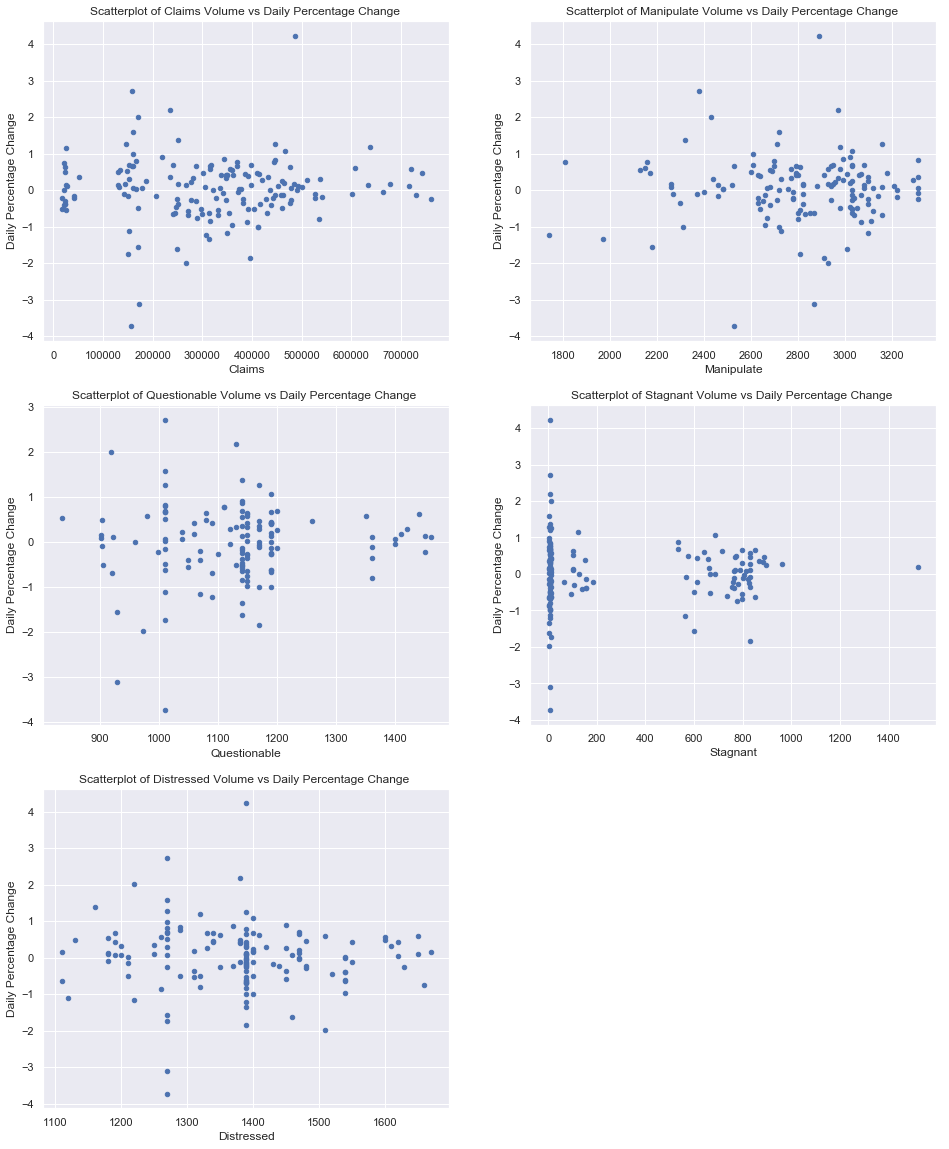

In [42]:
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
ax4 = fig.add_subplot(3,2,4)
ax5 = fig.add_subplot(3,2,5)

Claims_cleaned_df.plot(kind='scatter', 
                    x='Claims', y='Daily Percentage Change',
                    figsize=(16,20),ax = ax1, title='Scatterplot of Claims Volume vs Daily Percentage Change ')

Manipulate_cleaned_df.plot(kind='scatter', 
                    x='Manipulate', y='Daily Percentage Change',
                    figsize=(16,20),ax = ax2, title='Scatterplot of Manipulate Volume vs Daily Percentage Change ')

Questionable_cleaned_df.plot(kind='scatter', 
                    x='Questionable', y='Daily Percentage Change',
                    figsize=(16,20),ax = ax3, title='Scatterplot of Questionable Volume vs Daily Percentage Change ')

Stagnant_cleaned_df.plot(kind='scatter', 
                    x='Stagnant', y='Daily Percentage Change',
                    figsize=(16,20),ax = ax4, title='Scatterplot of Stagnant Volume vs Daily Percentage Change ')

Distressed_cleaned_df.plot(kind='scatter', 
                    x='Distressed', y='Daily Percentage Change',
                    figsize=(16,20),ax = ax5, title='Scatterplot of Distressed Volume vs Daily Percentage Change ')

Subsequently, the scatter plots for the `postive` words

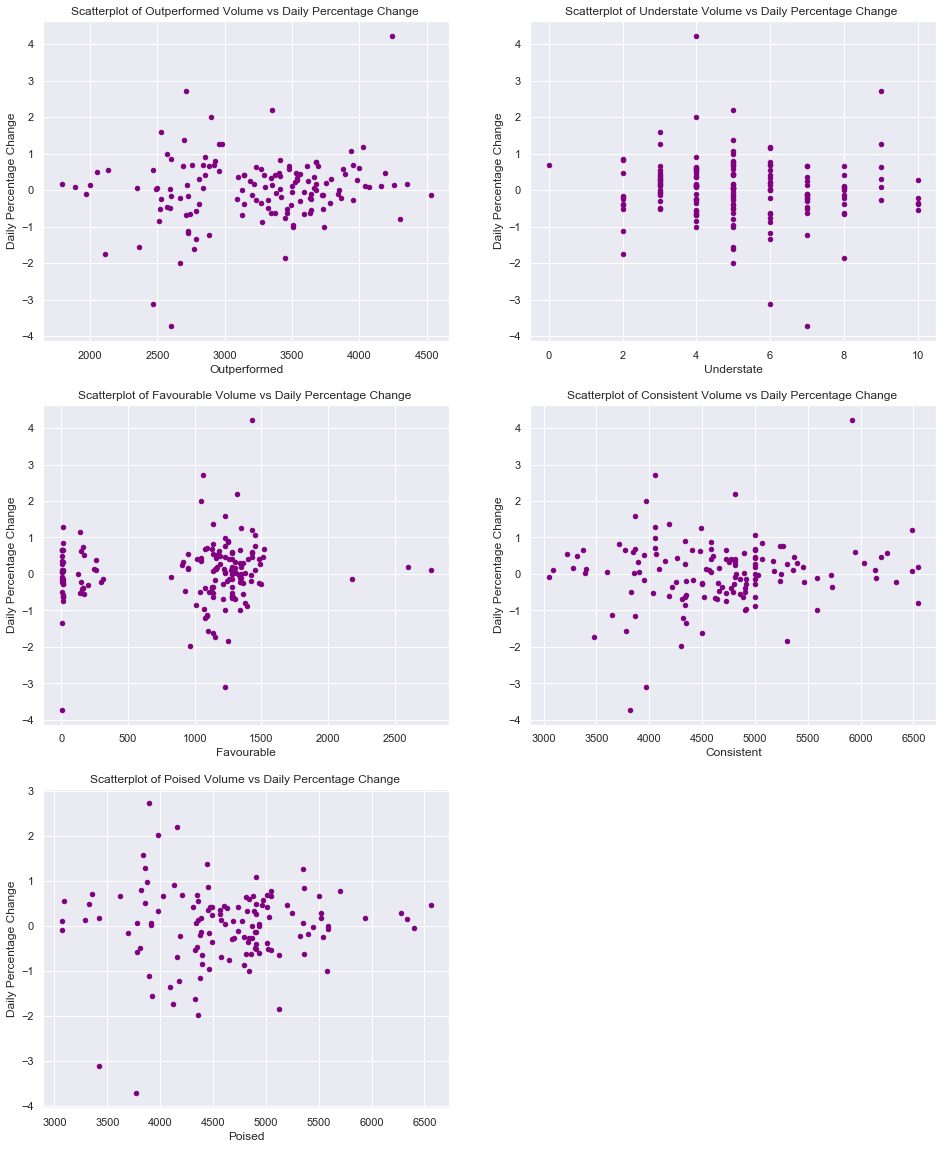

In [48]:
fig = plt.figure(figsize=(16, 10))
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
ax4 = fig.add_subplot(3,2,4)
ax5 = fig.add_subplot(3,2,5)

Outperformed_cleaned_df.plot(kind='scatter', 
                    x='Outperformed', y='Daily Percentage Change',
                    figsize=(16,20),ax = ax1,color = 'purple' , title='Scatterplot of Outperformed Volume vs Daily Percentage Change ')

Understate_cleaned_df.plot(kind='scatter', 
                    x='Understate', y='Daily Percentage Change',
                    figsize=(16,20),ax = ax2, color = 'purple', title='Scatterplot of Understate Volume vs Daily Percentage Change ')

Favourable_cleaned_df.plot(kind='scatter', 
                    x='Favourable', y='Daily Percentage Change',
                    figsize=(16,20),ax = ax3, color = 'purple' ,title='Scatterplot of Favourable Volume vs Daily Percentage Change ')

Consistent_cleaned_df.plot(kind='scatter', 
                    x='Consistent', y='Daily Percentage Change',
                    figsize=(16,20),ax = ax4,color ='purple', title='Scatterplot of Consistent Volume vs Daily Percentage Change ')


Poised_cleaned_df.plot(kind='scatter', 
                    x='Poised', y='Daily Percentage Change',
                    figsize=(16,20),ax = ax5,color ='purple', title='Scatterplot of Poised Volume vs Daily Percentage Change ')



In [50]:
# Finding the correlation


corr_df = pd.DataFrame(columns=['Keywords','Correlation with Price Change'])

corr_df['Keywords'] = Keyword_list

#pd.options.display.float_format = lambda x : '{:.10f}'.format(x) if int(x) == x else '{:,.10f}'.format(x)
def correlation(i):
    
    return(gbl[i+"_cleaned_df"]["Daily Percentage Change"].corr(gbl[i+"_cleaned_df"][i]))

corr_df['Correlation with Price Change'] = corr_df['Keywords'].apply(correlation)

corr_df

,Keywords,Correlation with Price Change
0,Claims,0.0502687117
1,Manipulate,0.0068546896
2,Questionable,0.0576973735
3,Stagnant,-0.0179485326
4,Distressed,-0.0516404277
5,Understate,-0.0795810030
6,Outperformed,0.1605756824
7,Favourable,0.0875794533
8,Consistent,0.0976417225
9,Poised,0.0418093961


After computing the correlations of each volume against the price changes of the index, we realised that there were surprising results from the correlation results. **Questionable** a word with a negative cognition has a positive correlation with the index's change in price. At the same time, **Understate** a word with a positive cognition has a negative correlation with the index's change in price.

We shortlisted 4 keywords to perform further analysis on. The 4 keywords either has an interesting correlation with the index (as stated above) or a high absolute correlation with the index 

We picked **Questionable,Consistent,Outperformed & Distressed**. Understate is excluded as the search volume number is rather low which can lead to inaccuracy in the evaluation. This might also be one of the reason why the word is negatively correlated with the index's change in price. Hence, it is appropriate for us to leave it out

Subsequently, we grouped the price percentage change by bins where the 4 keywords' volume are summed up in the range of [-4,-2,0,2,4]

In [53]:
# Take 4 Interesting Sample to plot

#Negative word but positively correlated. Hmm...
Questionable_filtered = Questionable_cleaned_df[['Date', 'Questionable']].copy()
#2nd postively word that is positively correlated. 
Consistent_filtered = Consistent_cleaned_df[['Date','Consistent']].copy()
#Top postively word that is positively correlated
Outperformed_filtered = Outperformed_cleaned_df[['Date','Outperformed']].copy()
#Top negatively word that is negatively correlated
Distressed_filtered = Distressed_cleaned_df[['Date','Distressed','Daily Percentage Change']].copy()

Histo_plot_df = pd.merge(pd.merge(pd.merge(Questionable_filtered,Consistent_filtered,on='Date'),Outperformed_filtered,on='Date'),Distressed_filtered, on='Date')
Histo_plot_df['bin'] = pd.cut(Histo_plot_df['Daily Percentage Change'], [-4,-2,0,2,4])

Histo_plot_final_df = Histo_plot_df[['Questionable','Consistent','Outperformed','Distressed','bin']]

Histo_plot_grouped_df = Histo_plot_final_df.groupby('bin').sum().reset_index()


Text(0,0.5,'Volume')

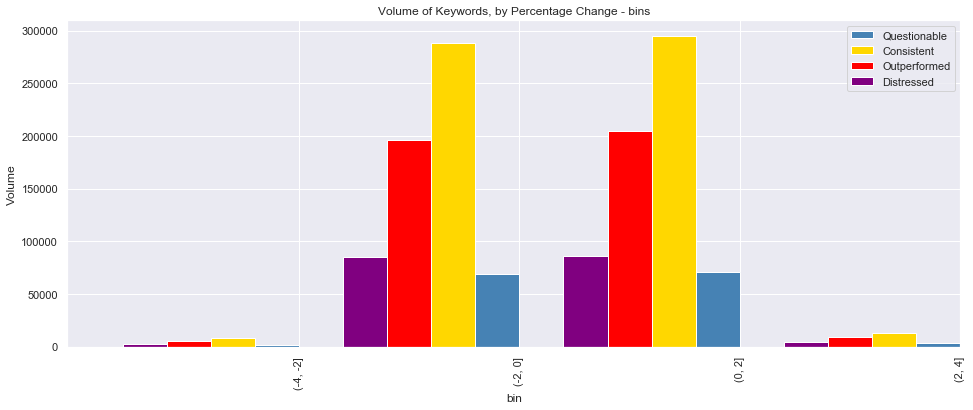

In [54]:
width=0.20

# Create the figure
fig = plt.figure(figsize=DIMS)

# Add the subplot
ax = fig.add_subplot(111)


Histo_plot_grouped_df.plot(kind='bar', x="bin", y='Questionable'
                            , ax=ax, position=1, color='steelblue'
                            ,width=width)
Histo_plot_grouped_df.plot(kind='bar', x="bin", y='Consistent'
                            , ax=ax, position=2, color='gold'
                            ,width=width)

Histo_plot_grouped_df.plot(kind='bar', x="bin", y='Outperformed'
                            , ax=ax, position=3, color='red'
                            ,width=width)

Histo_plot_grouped_df.plot(kind='bar', x="bin", y='Distressed'
                            , ax=ax, position=4, color='purple'
                            ,width=width)
# Add the title and y-label of the plot
#
ax.set_title('Volume of Keywords, by Percentage Change - bins')
ax.set_ylabel('Volume')

## Findings

From the graph, in the region of -2 to 2, we can that there is where most of the search volumes are. Most of the keywords have a relatively similar number in both the -2 to 0 and 0 to 2 region which signifies and further emphasis on the low absolute correlation with the index.

This clearly shows that the stock prices are not really affected by keywords of report on the index. This shows that further analysis of the stocks such as financial modelling, sensitive analysis with the usage of the financial statements could be more relavant and key to drive the change in the stock prices.  